# Bayesian statistics project

__Teachers__ : R. Bardenet, A. Simoni  
__Students__ : N. Ahmis, G. Demonet

## Table of Contents

+ [Bayesian LASSO](#Bayesian-LASSO)
    - [Laplace prior](#Park-and-Casella-model-of-Bayesian-LASSO)
    - [Jeffrey's hyperprior](#Jeffreys-hyperprior-for-$\lambda$)
    - [Half-Gaussian hyperprior](#Half-Gaussian-hyperprior-for-$\lambda$)

+ [Neural Network binary classification](#Bayesian-Learning-for-Neural-Network)
    - [Results](#Application-of-the-formula-to-the-ANN)

## Bayesian LASSO

### Data extraction

_Diabetes Data_ from Efron et al. (2004)

Exported from R package `lars`.  
n = 442 patients, with p = 10 predictor variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
diabetes = np.loadtxt(fname="diabetes.csv",
                      delimiter=",",
                      skiprows=1,
                      usecols=tuple(range(1,12)),
                      unpack=True, 
                      dtype=None)

In [3]:
X, y = diabetes[:-1,:].T, diabetes[-1]

Now that we have the data, let's observe quickly the marginal scatterplots :

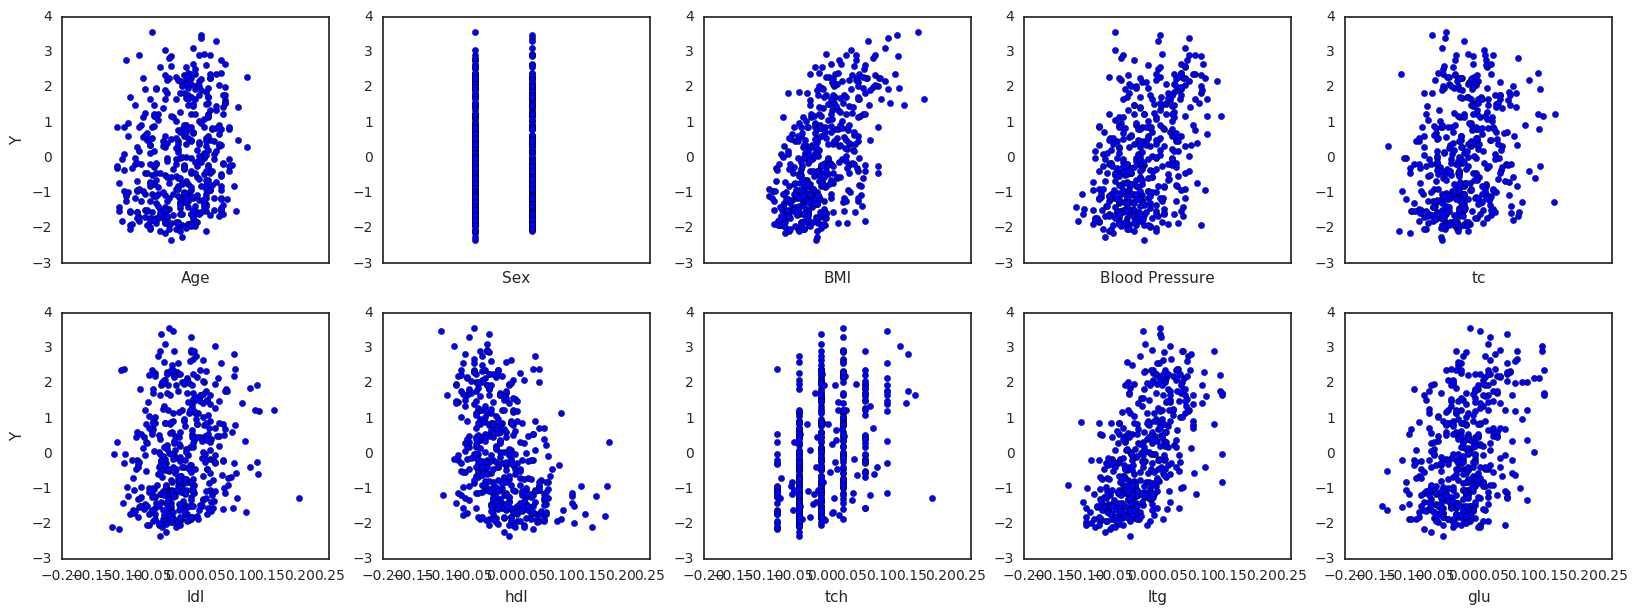

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, axes = plt.subplots(2, 5, sharex=True, figsize=(20,7))

#predictor variables names
names = ['Age', 'Sex', 'BMI', 'Blood Pressure', 'tc', 'ldl', 'hdl',
         'tch', 'ltg', 'glu']

for i in range(2):
    for j in range(5):
        k = 5*i + j
        axes[i,j].scatter(X[:,k], y)
        axes[i,j].set_xlabel(names[k]);
axes[0,0].set_ylabel('Y'); axes[1,0].set_ylabel('Y'); 

### Park and Casella model of Bayesian LASSO

We use the PyMC3 module for all our Bayesian models, taking advantage of the available fast implementations of MCMC algorithms and plotting utilities.

For more details on this module, please see :

+ [article](http://www.map.ox.ac.uk/media/PDF/Patil_et_al_2010.pdf)
+ [documentation](https://pymc-devs.github.io/pymc3/index.html)

In [5]:
from pymc3 import Model, Normal, Laplace

In [6]:
# pymc is based on theano
# for optimized computation
import theano
import theano.tensor as T
floatX = theano.config.floatX

X = X.astype(floatX)
y = y.astype(floatX)

In [7]:
import pymc3.math as pmm
laplace_model = Model()

#we use the article value to reproduce results
_lambda = 0.37

with laplace_model:
    
    # Prior for alpha
    alpha = Laplace('alpha', b = 1/_lambda, mu=0, shape=10)
    
    mu = T.dot(X,alpha)
    
    y_obs = Normal('Y_obs', mu=mu, sd=1, observed=y)

The MCMC algorithm used to sample $\alpha$ values is called NUTS, for No U-Turn Sampler (which is based on Variational Inference).

In [8]:
from pymc3 import NUTS, sample
from scipy import optimize

with laplace_model:
    
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -645.14: 100%|██████████| 200000/200000 [00:19<00:00, 10475.53it/s]
Finished [100%]: Average ELBO = -645.14
100%|██████████| 10000/10000 [00:19<00:00, 518.15it/s]


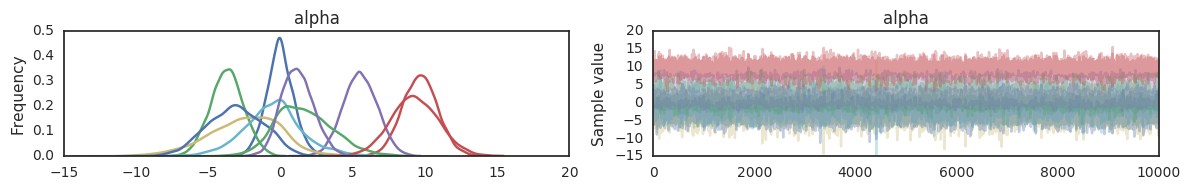

In [9]:
from pymc3 import traceplot

traceplot(trace);

In [10]:
from pymc3 import summary

summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.038           0.944            0.008            [-1.943, 1.820]
  -3.699           1.149            0.010            [-5.963, -1.442]
  9.643            1.222            0.012            [7.219, 11.981]
  5.518            1.187            0.011            [3.241, 7.852]
  -2.432           2.541            0.052            [-7.820, 2.120]
  -0.539           2.090            0.042            [-4.599, 3.945]
  -3.109           1.940            0.039            [-6.824, 0.494]
  1.650            1.999            0.041            [-2.015, 5.756]
  9.275            1.668            0.026            [6.056, 12.612]
  1.160            1.112            0.011            [-0.905, 3.394]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  


We could have used PyMC3 optimization function to find the _Maximum A Posteriori_, like this :

In [11]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=laplace_model)

print(map_estimate)

         Current function value: 653.571037
         Iterations: 13
         Function evaluations: 95
         Gradient evaluations: 92
{'alpha': array([ -3.09944962e-04,  -3.68799377e+00,   9.59236973e+00,
         5.52885435e+00,  -1.91759831e+00,  -1.89757168e-02,
        -4.09112341e+00,   1.26891691e-01,   9.49245782e+00,
         9.73025261e-01])}


### Results checking and _general accuracy formula_

As in Efron's article, we specify the following equations :

$$ \mathbf{y}|\alpha \sim \mathcal{N}_n(\mathbf{X}\alpha, 1)$$

$\mathbf{X}$ a $n \times p$ matrix et $\mathbf{y}$  $n$-dimensional answer vector.  
The joint prior distribution for $\alpha$ is :

$$\pi(\alpha) = \frac{\lambda^p}{2} exp( - \lambda L_1(\alpha) )$$

with $\lambda = 0.37$ et $L_1(\alpha) = \sum_1^{10} |\alpha_j|$.

The MCMC algorithm generates $B = 10000$ $\alpha$ values.

Now we're able to work on $\hat{\theta} = \sum_{i=1}^B t(\alpha_i) / B$.

**General accuracy formula in this case**

$$t_i = t(\alpha_i) \, \text{and} \, \gamma_i = \gamma_{\hat{\beta}} (\alpha_i)$$

where $\hat{\beta} = \mathbf{X}^T \mathbf{y}$ 

$$\widehat{\text{cov}} = B^{-1} \sum_{i=1}^B (\gamma_i - \bar{\gamma})(t_i - \bar{t})$$

since $\hat{\beta} | \alpha \sim \mathcal{N}_n (G \alpha, G)$ where $G = \mathbf{X}^T\mathbf{X}$, we have an exponential family, and result $(3.3)$ from the paper applies. We thus replace $\gamma_i$ by $\alpha_i$ that we sampled in the expression for $\widehat{\text{cov}}$.

We then have :

$$\widehat{\text{sd}} = [\widehat{\text{cov}}^T \, G \, \widehat{\text{cov}}]^{\frac{1}{2}}$$

#### Patient 125 : comparison with the article

We consider estimating : $t(\alpha) = x_{125} \alpha$

In [12]:
X125 = X[124]

In [13]:
t = X125.dot(trace['alpha'].T)

In [14]:
np.mean(t) #theta hat

0.24599089847500177

In [15]:
np.std(t) #bayesian std

0.072537490064495252

Results are similar indeed : $x_{125} \alpha_i \sim (0.246, 0.072²)$. Let us check the frequentist standard deviation now.

__Frequentist standard deviation__

noted `std_freq` using the general accuracy formula

In [16]:
alpha_bar = np.mean(trace['alpha'], axis=0)
t_bar = np.mean(t)

In [17]:
t_tilde = t - t_bar
alpha = trace['alpha'] - alpha_bar
cov = alpha.T.dot(t_tilde) / 10000

In [18]:
G = X.T.dot(X)

In [19]:
std_freq = np.sqrt(cov.T.dot(G).dot(cov))
std_freq

0.071733047189813756

We find $\widehat{\text{sd}} \simeq 0.071$ as in the article. We can assume our set up is then correct.

#### Ratios frequentist std over bayesian std

Compute all $\gamma_i = \mathbf{x}_i \alpha$ estimates from the sample and their standard deviations.

In [20]:
ts = X.dot(trace['alpha'].T)
ts_tilde = ts.T - np.mean(ts, axis=1)

In [21]:
covs = alpha.T.dot(ts_tilde) / 10000

In [22]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

In [23]:
stds_bay = np.std(ts,axis=1)

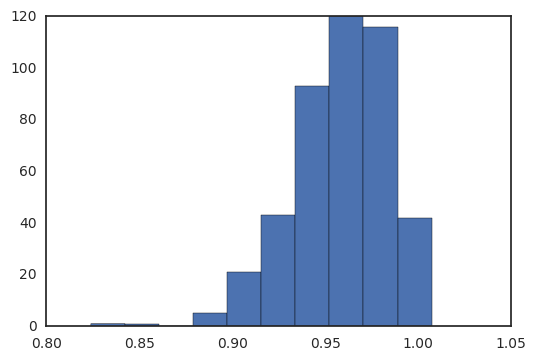

In [25]:
plt.hist(stds_freq/stds_bay);

#### MSE comparison

For curiosity purposes

In [26]:
map_alpha = map_estimate['alpha']

y_map = np.dot(X, map_alpha)

In [30]:
np.mean(np.square(np.mean(y)-y))

2.0220051018241425

In [31]:
np.mean(np.square(y_map-y))

0.98378850115135552

In [32]:
y_hat = np.mean(ts, axis=1)
np.mean(np.square(y_hat-y))

0.9823029039904938

The maximum a posteriori predictive distribution gives a 2x better MSE than a naive constant estimator, and the MCMC estimator yields a slightly better result.

## Jeffreys hyperprior for $\lambda$

We can easily compute that Jeffrey's prior for $\lambda$ verifies :

$$\pi(\lambda) \propto \frac{1}{\lambda}$$

We thus adjust the PyMC model accordingly :

In [33]:
from pymc3 import Uniform

jeff_model = Model()

with jeff_model:
    
    # Hyperprior for lambda
    _lambda = Uniform('lambda', 0, 1)
    
    # Prior for alpha
    alpha = Laplace('alpha', b = 1/_lambda, mu=0, shape=10)
    
    mu = T.dot(X,alpha)
    
    y_obs = Normal('Y_obs', mu=mu, sd=1, observed=y)

In [34]:
with jeff_model:
    
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -646.06: 100%|██████████| 200000/200000 [00:27<00:00, 7395.74it/s]
Finished [100%]: Average ELBO = -646.02
100%|██████████| 10000/10000 [00:30<00:00, 325.27it/s]


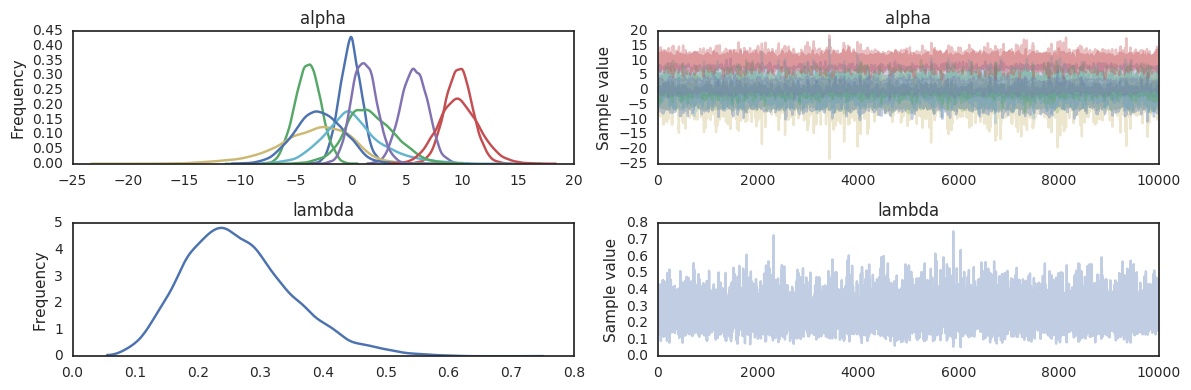

In [35]:
traceplot(trace);

In [36]:
G = X.T.dot(X)

In [37]:
ts = X.dot(trace['alpha'].T)
ts_tilde = ts.T - np.mean(ts, axis=1)

In [38]:
alpha = trace['alpha'] - np.mean(trace['alpha'], axis=0)

In [39]:
covs = alpha.T.dot(ts_tilde) / 10000

In [40]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

In [41]:
stds_bay = np.std(ts,axis=1)

On patient 125, this method leads to a higher standard deviation, both frequentist and bayesian.

In [42]:
stds_bay[124]

0.074612975945298185

In [43]:
stds_freq[124]

0.075168616022903714

However, it also leads to a lightly better MSE for prediction.

In [44]:
y_hat = np.mean(ts, axis=1)
np.sum(np.square(y_hat - y))

433.4321912489176

## Half-Gaussian hyperprior for $\lambda$

In [45]:
from pymc3 import HalfNormal

hg_model = Model()

with hg_model:
    
    # Hyperprior for lambda
    _lambda = HalfNormal('lambda', sd=1)
    
    # Prior for alpha
    alpha = Laplace('alpha', b = 1/_lambda, mu=0, shape=10)
    
    mu = T.dot(X,alpha)
    
    y_obs = Normal('Y_obs', mu=mu, sd=1, observed=y)

In [46]:
with hg_model:
    
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -646.33: 100%|██████████| 200000/200000 [00:24<00:00, 8254.22it/s]
Finished [100%]: Average ELBO = -646.35
100%|██████████| 10000/10000 [00:30<00:00, 328.41it/s]


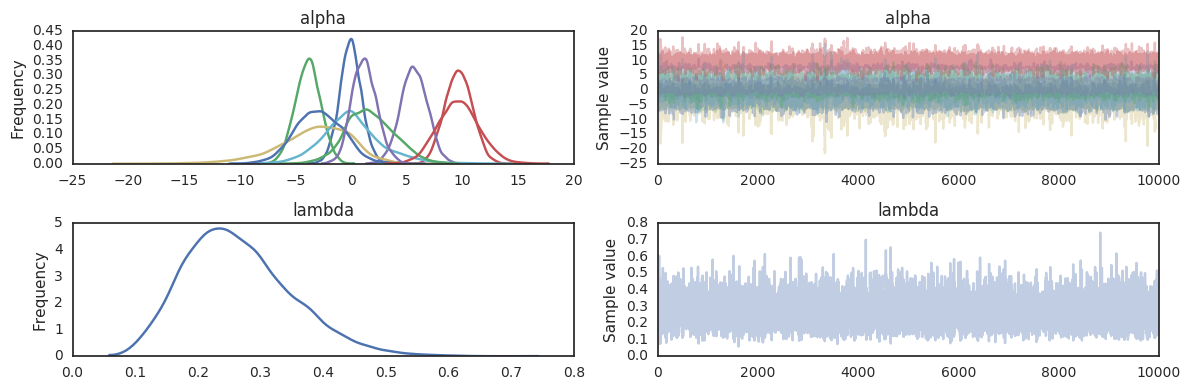

In [48]:
traceplot(trace);

In [49]:
G = X.T.dot(X)

In [50]:
ts = X.dot(trace['alpha'].T)
ts_tilde = ts.T - np.mean(ts, axis=1)

In [51]:
alpha = trace['alpha'] - np.mean(trace['alpha'], axis=0)

In [52]:
covs = alpha.T.dot(ts_tilde) / 10000

In [53]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

In [54]:
stds_bay = np.std(ts,axis=1)

On patient 125, the Gaussian hyperprior leads to lower uncertainty than the Jeffrey's prior, both frequentist and bayesian.

In [55]:
stds_bay[124]

0.073066249382152004

In [56]:
stds_freq[124]

0.07216969852787973

However, MSE performance is similar.

In [57]:
y_hat = np.mean(ts, axis=1)
np.sum(np.square(y_hat - y))

433.47470717020485

## Bayesian Learning for Neural Network

From the PyMC3 documentation, we modify the example to fit the single hidden layer MLP presented in Neal's thesis.

### Synthetic data generation

In [58]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [59]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

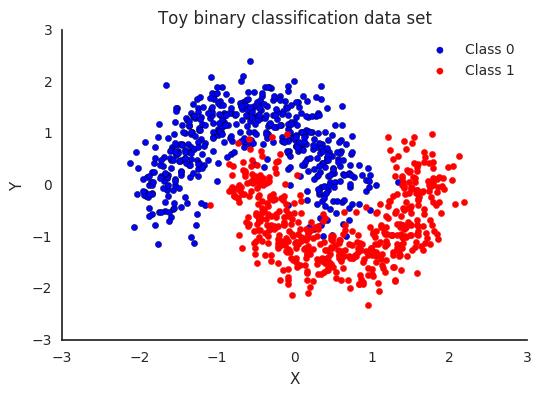

In [60]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

We now define our Bayesian neural network for binary classification (output follows a Bernouilli distribution).

In [61]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 10

# Initialize random weights and biases between each layer
# hidden layer
init_wh = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_bh = np.random.randn(n_hidden).astype(floatX)
# output layer
init_wo = np.random.randn(n_hidden).astype(floatX)
init_bo = np.random.randn()

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_ih = pm.Normal('w_ih', 0, sd=1,
                            shape=(X.shape[1], n_hidden),
                            testval=init_wh)
    # Biases from input to hidden layer
    biases_ih = pm.Normal('b_ih', 0, sd=1,
                            shape=n_hidden,
                            testval=init_bh)

    # Weights from hidden layer to output
    weights_ho = pm.Normal('w_ho', 0, sd=1,
                            shape=(n_hidden,),
                            testval=init_wo)
    biases_ho = pm.Normal('b_ho', 0, sd=1,
                            testval=init_bo)

    # Build neural-network using tanh activation function
    act_hid = pm.math.tanh(biases_ih + \
                           pm.math.dot(ann_input,weights_ih))
    act_out = pm.math.sigmoid(biases_ho + \
                              pm.math.dot(act_hid, weights_ho))
    
    sigmoid_out = pm.Deterministic('sig_out', act_out)
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

In [62]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Average ELBO = -131.74: 100%|██████████| 50000/50000 [00:23<00:00, 2143.62it/s]
Finished [100%]: Average ELBO = -129.98


CPU times: user 25.7 s, sys: 532 ms, total: 26.3 s
Wall time: 25.3 s


In [63]:
%%time

with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:02<00:00, 2282.69it/s]

CPU times: user 3.22 s, sys: 48 ms, total: 3.26 s
Wall time: 3.12 s


### Prediction with the model

In [65]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:05<00:00, 96.75it/s]


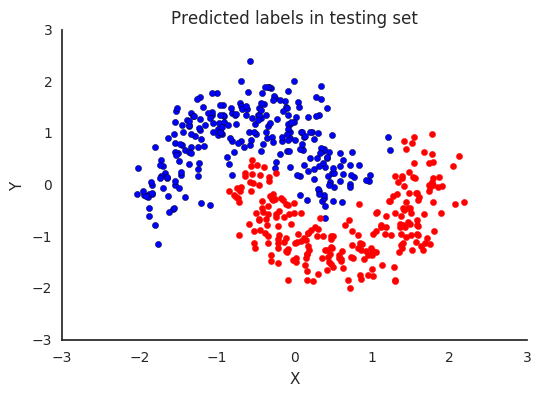

In [66]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [67]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.6%


### Uncertainty as maps

Using a grid, we use posterior predictive distribution to estimate the regions of uncertainty.

In [68]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [69]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network)

100%|██████████| 5000/5000 [01:11<00:00, 69.76it/s]


Actual posterior predictive probability map :

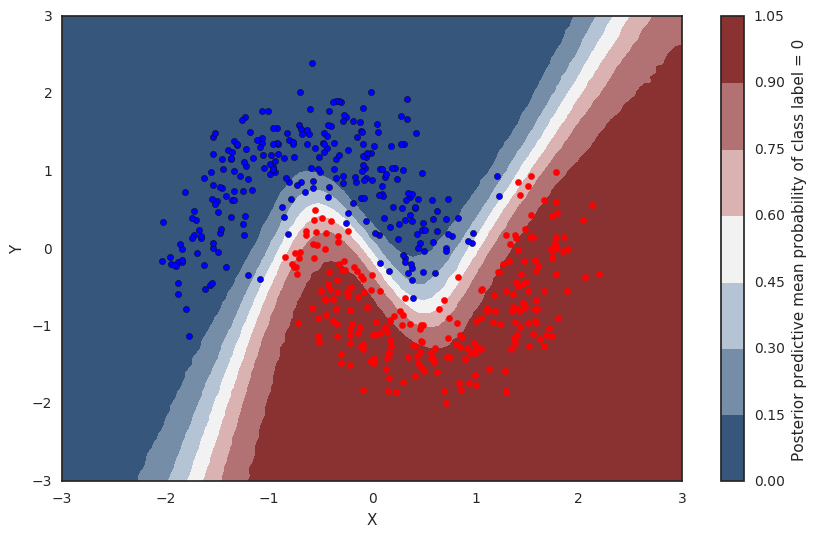

In [70]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

We can easily compute the bayesian standard deviations for these prediction, which is a useful aspect of Bayesian Learning when applied to the "black boxes" that are neural networks.

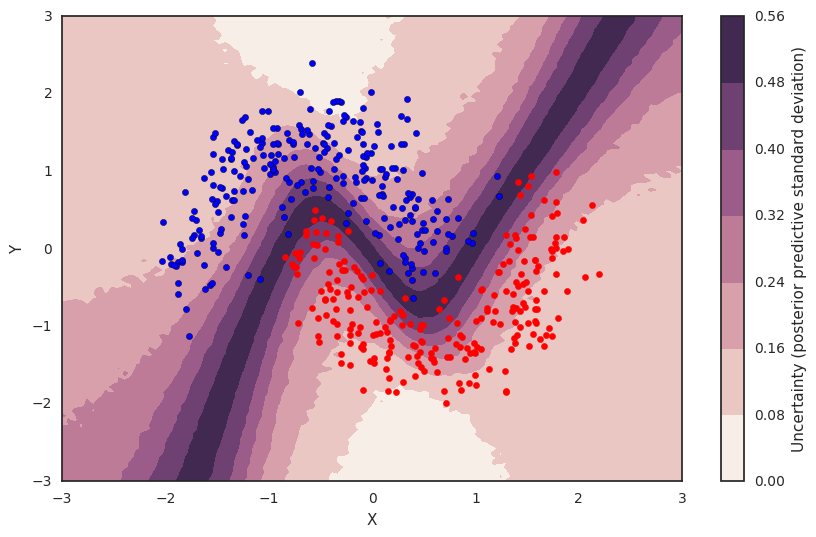

In [71]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### Application of the formula to the ANN

Goal now would be to compare the predictive Bayesian standard deviation to the frequentist standard deviation (obtained from the general accuracy formula). Using the trivial sufficient statistic $y$, which verifies $y_i|\theta \sim Bernouilli(p_{i, \theta})$ (with $p_{i, \theta}$ being the response of the network to the signal $X_i$), we can apply the formula in the simple exponential case. We represent $\theta$ as a 41-dimensional vector (all parameters stacked)

In [72]:
ts = ppc['out']
ts_tilde = ts - ppc['out'].mean(axis=0)

In [73]:
wh = trace['w_ih']
bh = trace['b_ih']
wo = trace['w_ho']
bo = trace['b_ho']

In [74]:
flat_wh = wh.reshape((5000,20))
vect_bo = bo.reshape((5000,1))
alpha = np.hstack((flat_wh, bh, wo, vect_bo))

In [75]:
alpha = alpha - np.mean(alpha, axis=0)

In [76]:
G = np.cov(alpha.T)

In [77]:
covs = alpha.T.dot(ts_tilde) / 500

In [78]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

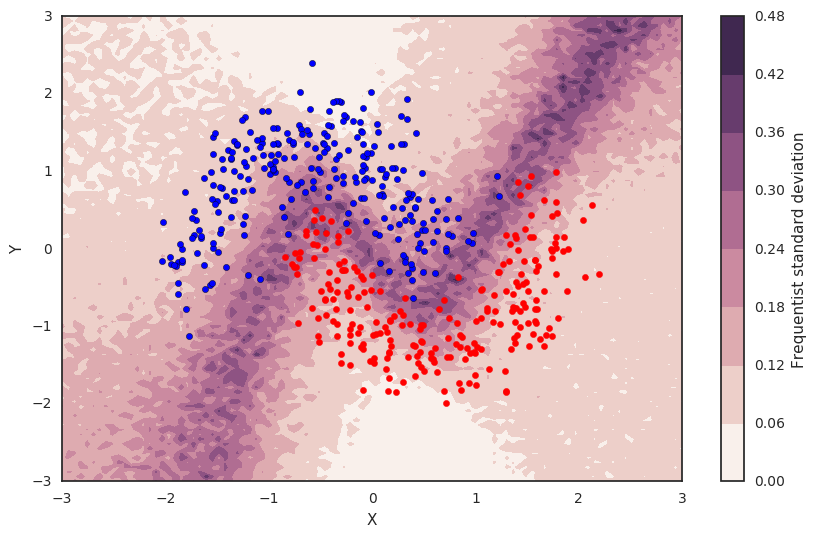

In [79]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, stds_freq.reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Frequentist standard deviation');